In [6]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools

import warnings as w
from IPython.display import Image

from utils import qualityMACAPE, qualityRMSE, \
InitExponentialSmoothing, AdaptiveExponentialSmoothing, WintersExponentialSmoothing

%matplotlib inline

<h1 align="center"> Practice: realize compositions</h1>
# Adaptive selection
** Question:**
* What is adaptive selection?
* Which external parameters does it have?
* Describe case when adaptive selection works bad.

In [7]:
def MAE(x, predicted):
    return np.abs(x - predicted)

def MSE(x, predicted):
    return (x - predicted) ** 2

def exp_MAE(x, predicted):
    return np.exp(np.abs(x - predicted))

def exp_MSE(x, predicted):
    return np.exp((x - predicted) ** 2)

# Define base algorithms

In [8]:
base_algs = [{'base_alg':'InitExponentialSmoothing', 'base_algs_params':{'alpha':0.9, 'AdaptationPeriod':10}},
            {'base_alg':'AdaptiveExponentialSmoothing', 'base_algs_params':{'alpha':0.2,'gamma':0.01, 'AdaptationPeriod':10}},
            {'base_alg':'AdaptiveExponentialSmoothing', 'base_algs_params':{'alpha':0.2,'gamma':1, 'AdaptationPeriod':10}},
#            {'base_alg':'AdaptiveSimpleExponentialSmoothing', 'base_algs_params':{'alpha':0.1, 'gamma':0.01}},
            {'base_alg':'WintersExponentialSmoothing', 'base_algs_params':{'alpha':0.3, 'beta':0.9,'delta':0.9, 'gamma':0.1, 'seasonality_period':1}}
]

In [9]:
for ba in range(len(base_algs)):
    print(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_alg_params'])")

InitExponentialSmoothing(x,h,base_algs[0]['base_alg_params'])
AdaptiveExponentialSmoothing(x,h,base_algs[1]['base_alg_params'])
AdaptiveExponentialSmoothing(x,h,base_algs[2]['base_alg_params'])
WintersExponentialSmoothing(x,h,base_algs[3]['base_alg_params'])


In [10]:
# Read data (time series)
ts = pd.read_csv('https://raw.githubusercontent.com/ml-mipt/ml-mipt-part2/master/2017/seminars/1_ts_esm/data/TimeSeries_Data10.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
# ts = pd.read_csv('./data/TimeSeries_Data10.csv', sep=',', decimal='.')
ts = ts.sort_index() # sort index

In [11]:
# Define forecast perameters
h =1 # horizon forecast

# structure of forecasts
frc_ts = pd.DataFrame(index = ts.index.append(pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h)))
                      , columns = ts.columns)
FRC_TS = dict()

In [12]:
# run (build forecast) simple exponential smoothing
for cntr in ts.columns:
    frc_ts[cntr]= AdaptiveExponentialSmoothing(ts[cntr],h, {'alpha':0.1,'gamma':0.01,  'AdaptationPeriod':10})

# Aggregating Algorithm
* Descibe parameters of AA:
    - $\beta$ - parametr of mixability
    - $S(g)$ - substitution function
    - $p_j$ - initial distribution of base algorithms
d* Write down theoretical boundary for AA

In [13]:
losses = []

In [14]:
def norm_log_weights(weights):
    #"norm weigths ore whatever comes in (beta)"
    minima = np.min(weights)
    maxim = np.max(weights)
    weights = weights - minima - (maxim - minima) / 2
    #if (np.max(weights) - np.min(weights) > 10):
    #    weights -= np.max(weights) - 5
    weights = np.maximum(weights, -500)
    weights = np.minimum(weights, 500)
    return weights
    

def calc_g(Y, predicted, function, weights_log, beta):
    g = 0
    weights = get_weights(weights_log)
    #weights = sigmoid(weights)
    g = np.sum(weights * np.power(beta, function(Y, predicted)))
    g = np.log(g) / np.log(beta)
    if np.isinf(g):
        print("TTTT")
    return g

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def upper_bound(current_loss, Y1, Y2, M = 2):
    K = 2
    alpha = math.sqrt((Y2 - Y1) * K * np.log(M) / (4 * np.min(current_loss)))
    L = (1 + alpha) * np.min(current_loss) + (1 + alpha) / alpha * (Y2 - Y1) * K / 4 * np.log(M)
    return L

def get_weights(log_weights):
    res = np.exp(log_weights)
    res /= np.sum(res)
    return res


In [15]:
#from utils import norm_log_weights, calc_g, sigmoid, upper_bound

ensemble_losses = []
bound = []


def aa_composition(x, h, params, function = MAE, debug = False):
    '''
    Parameters
    x <array> - time series
    h <integer scalar>- forecasting delay
    params <dict> - dictionary with 
    beta <scalar in [0,1]> - mixability parameter 
    weights <array in [0,1]> - initial weights of base_algs
    base_algs - array of <dict> with params
        base_alg <string> - name of base algorithm
        base_alg_params <dict> dictionary of base algorithm's params
    '''
    T = len(x)
    FORECAST = [np.NaN]*(T+h)
    # base algs Forecasts
    base_algs = params['base_alg_params']
    N = len(base_algs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    #     forecast TS by each base algs
    #     be careful with eval() function    
    for ba in range(len(base_algs)):
        FORECAST_BA[ba]= eval(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_alg_params'])")
    # internal params of composition
    beta = params['beta']
    weights = params['weights']
    weights_log = np.log(weights)
    if beta>1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if beta<0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST
    loss = np.zeros((len(base_algs)))
    #probably insert here pre-calculation of Y1 - averall min and Y2 - averall max
    #or insert it normal-mode - online calculation before g() calsualtion
    #Y1 = np.min(x)
    #Y2 = np.max(x)
    y = 1
    cum_ensemble_loss = 0
    ensemble_losses = []
    bound = []
    for t in range(0, T):
        if not math.isnan(x[t]):
            predicted = FORECAST_BA.transpose()[t + 1]
            current_loss = function(x[t], predicted)
            loss += current_loss
            weights_log = np.log(beta) * loss
            weights_log = norm_log_weights(weights_log)
            weights = get_weights(weights_log)
            Y1 = np.min(x[:t + 1])
            Y2 = np.max(x[:t + 1])
            #beta = np.exp(-2. / ((Y2 - Y1) ** 2))
            gY1 = calc_g(Y1, predicted, function, weights_log, beta)
            gY2 = calc_g(Y2, predicted, function, weights_log, beta)
            ub = upper_bound(loss, Y1, Y2)
            if (function == MAE):
                #MAE case
                y = (Y2 * gY1 + Y1 * gY2) / (gY1 + gY2)
            else:
                y = (Y2 * np.sqrt(gY1) + Y1 * np.sqrt(gY2)) / (np.sqrt(gY1) + np.sqrt(gY2))
                #y = yAA = (gY1 - gY2) / 2 / (Y2 - Y1 + 0.0000000001) + (Y1 + Y2) / 2
            ensemble_loss = function(y, x[t])
            if (not math.isnan(ensemble_loss)):
                #print(cum_ensemble_loss, ' ', ensemble_loss)
                cum_ensemble_loss += ensemble_loss
            bound.append(ub)
            ensemble_losses.append(cum_ensemble_loss)
                
        FORECAST[t+h] = y
    return FORECAST, ensemble_losses, bound

In [16]:
# run (build forecast) Aggregating Algorithm

h =1 # forecast horizon

base_algs = [{'base_alg':'InitExponentialSmoothing', 
              'base_alg_params':{'alpha':0.9, 'AdaptationPeriod':10}},
            {'base_alg':'AdaptiveExponentialSmoothing', 
             'base_alg_params':{'alpha':0.2,'gamma':0.01, 'AdaptationPeriod':10}},
            #{'base_alg':'AdaptiveExponentialSmoothing', 
            #'base_alg_params':{'alpha':0.2,'gamma':1, 'AdaptationPeriod':10}}
            #{'base_alg':'AdaptiveSimpleExponentialSmoothing', 
            #'base_algs_params':{'alpha':0.1, 'gamma':0.01}},            
]

# define base algorithm
frc_ts = pd.DataFrame(index = ts.index.append(
    pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h))), columns = ts.columns)
FRC_TS = dict()

beta = 0.9
bound_res = ensemble_losses_res = []
for cntr in ts.columns:
    frc_ts[cntr], ensemble_losses, bound = aa_composition(ts[cntr],h, 
                                  {'beta':0.9, 'weights': np.array([0.5, 0.5]), 'base_alg_params':base_algs}, 
                                  function = MAE, debug = True)
    if (ensemble_losses != []):
        bound_res = bound
        ensemble_losses_res = ensemble_losses
FRC_TS['AA beta %.2f' % (beta)] = frc_ts

C:\Users\alexr\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\alexr\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars


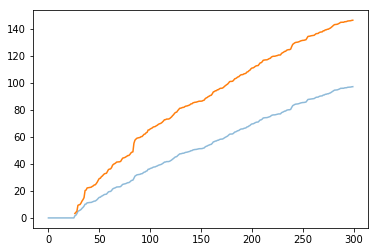

In [17]:
import matplotlib.pyplot as plt

#ensemble_losses.append(10)
ll = 300
plt.plot(range(len(ensemble_losses_res[:ll])), np.array(ensemble_losses_res[:ll]), alpha = 0.5)
plt.plot(range(len(bound_res[:ll])), np.array(bound_res[:ll]))

In [18]:
ensemble_losses_res

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1.575023957422077,
 2.038839762463675,
 3.1991544568546026,
 4.875955058187495,
 5.247721722604255,
 5.685463877499701,
 6.202852619065863,
 7.100044445025921,
 7.792266004732447,
 8.739766778040359,
 10.158439217837897,
 10.253218295269674,
 11.139460525024923,
 11.267514064443684,
 11.338078887663226,
 11.444012081429042,
 11.453809423895084,
 11.780709808914288,
 12.039682371798754,
 12.418453542142954,
 12.483952098740192,
 13.002093394465096,
 13.663283882587638,
 14.51443285521024,
 15.235289275932525,
 15.31115829145658,
 16.010760915132952,
 16.34030788729144,
 16.877066194952718,
 17.324533529750205,
 17.480581924094356,
 17.56516693886625,
 18.476762981453163,
 19.286068078913825,
 19.505788342915928,
 19.583652116834823,
 20.192462918813067,
 21.332532816912035,
 21.81847610820927,
 22.06727166399633,
 22.392468836049577,
 22.86007050441053,
 22.906920740337178,
 23.00223

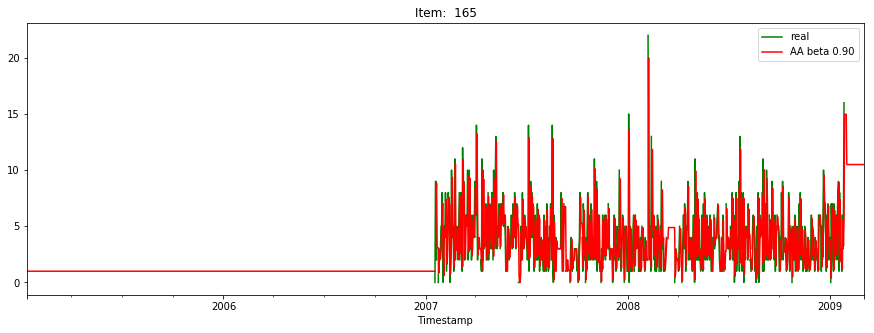

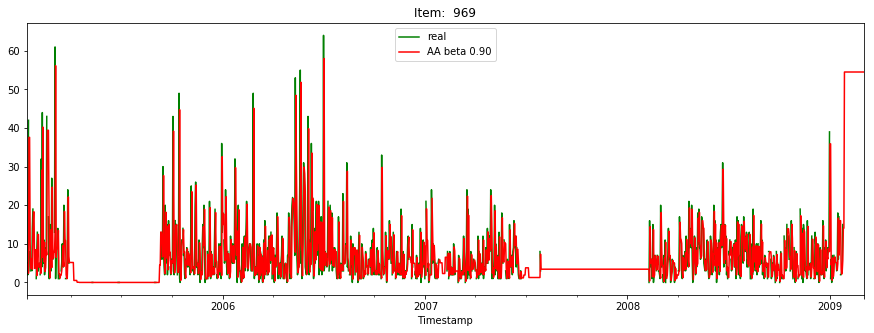

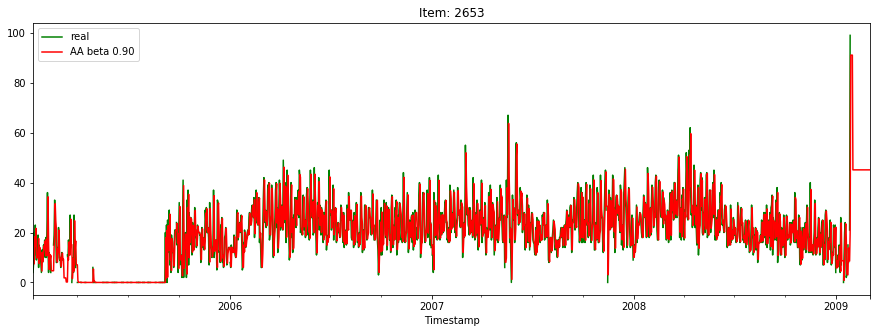

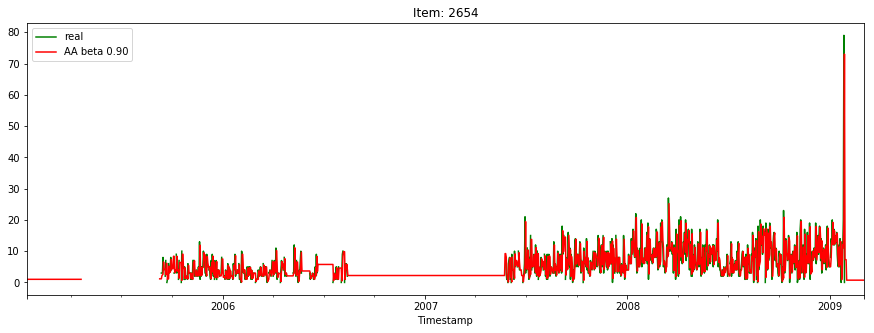

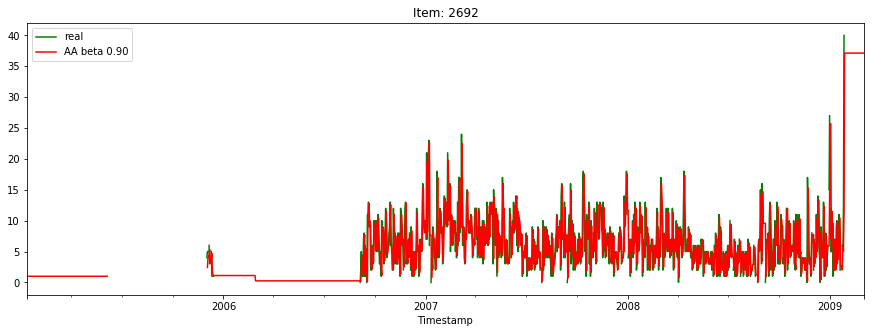

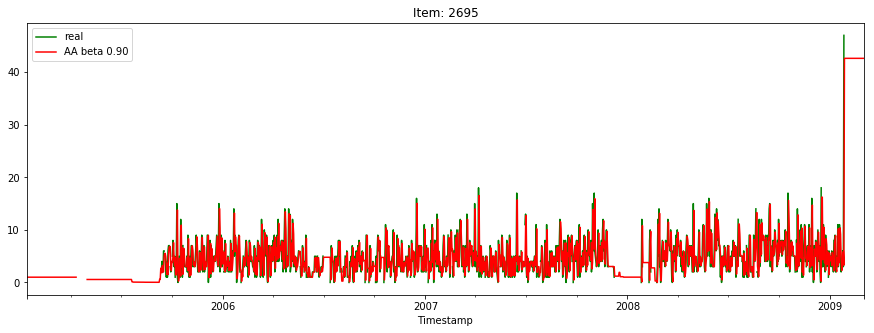

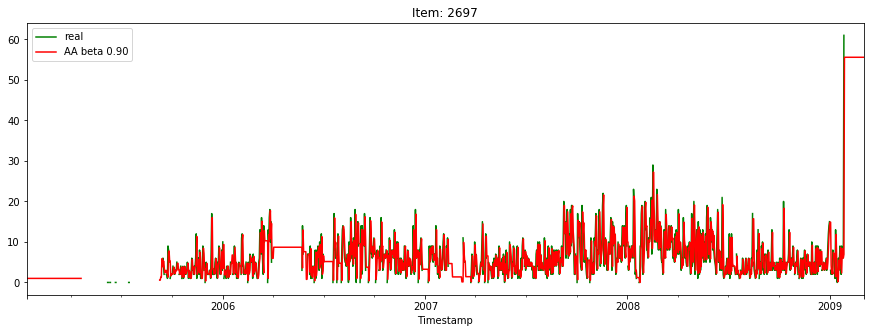

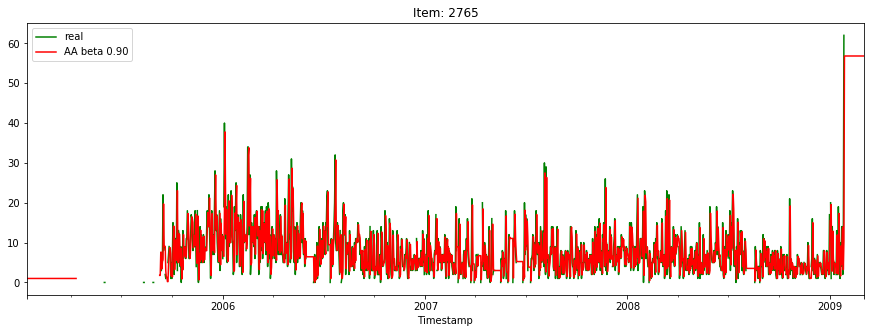

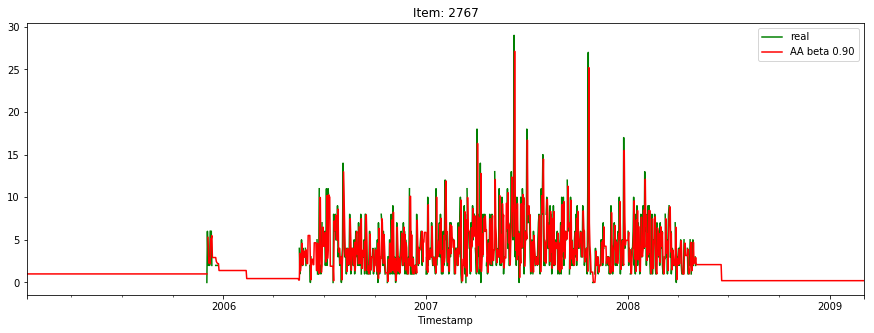

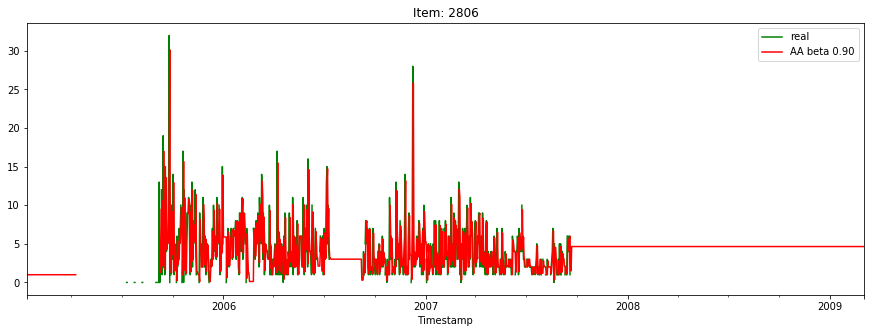

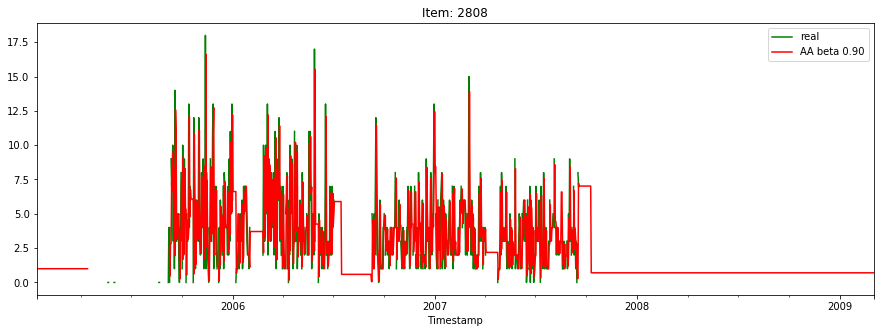

In [19]:
# draw forecast of Aggregating Algorithm
alg_name = 'AA beta 0.90'
for col in ts.columns:
    ts[col].plot(figsize=(15,5), color='green', label='real')
    forecast = FRC_TS[alg_name]
    forecast[col].plot(color='red', label=alg_name)
    plt.title(col)
    plt.legend()
    plt.show()